In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

from tensorflow.keras.preprocessing.image import ImageDataGenerator 
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU

In [2]:
BATCH_SIZE = 20

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        directory=r"./images/",
        target_size=(64, 64),
        batch_size=BATCH_SIZE,
        classes=None,
        class_mode=None,
        shuffle=True,
        color_mode = 'rgb')

Found 63500 images belonging to 1 classes.


In [4]:
#BUFFER_SIZE = train_generator.samples // BATCH_SIZE * BATCH_SIZE

In [5]:
# количество входных параметров генератора случайных чисел
hidden_dim = 20

In [6]:
# генератор

generator = tf.keras.Sequential()
generator.add(Dense(16 * 16 * 256, activation='selu', input_shape=(hidden_dim,)))
generator.add(Reshape((16, 16, 256)))
#generator.add(Dropout(0.3))
generator.add(BatchNormalization(momentum=0.9, epsilon=0.000001))

generator.add(Conv2DTranspose(1024, (4, 4), strides=(1, 1), padding='same', activation='selu'))
#generator.add(Dropout(0.3))
generator.add(BatchNormalization(momentum=0.9, epsilon=0.000001))

generator.add(Conv2DTranspose(512, (4, 4), strides=(1, 1), padding='same', activation='selu'))
#generator.add(Dropout(0.3))
generator.add(BatchNormalization(momentum=0.9, epsilon=0.000001))

generator.add(Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', activation='selu'))
#generator.add(Dropout(0.3))
generator.add(BatchNormalization(momentum=0.9, epsilon=0.000001))

generator.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', activation='selu'))
#generator.add(Dropout(0.3))
generator.add(BatchNormalization(momentum=0.9, epsilon=0.000001))

generator.add(Conv2DTranspose(3, (4, 4), strides=(1, 1), padding='same', activation='sigmoid'))

In [7]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 65536)             1376256   
                                                                 
 reshape (Reshape)           (None, 16, 16, 256)       0         
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 256)      1024      
 ormalization)                                                   
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 1024)     4195328   
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 1024)     4096      
 hNormalization)                                                 
                                                        

In [8]:
# дискриминатор
discriminator = tf.keras.Sequential()

discriminator.add(Conv2D(128, (4, 4), strides=(1, 1), padding='same', input_shape=[64, 64, 3]))
#discriminator.add(Dropout(0.4))
discriminator.add(BatchNormalization(momentum=0.9, epsilon=0.000001))
discriminator.add(LeakyReLU(alpha=0.2))

discriminator.add(Conv2D(128, (4, 4), strides=(1, 1), padding='same'))
#discriminator.add(Dropout(0.4))
discriminator.add(BatchNormalization(momentum=0.9, epsilon=0.000001))
discriminator.add(LeakyReLU(alpha=0.2))

discriminator.add(Conv2D(64, (4, 4), strides=(1, 1), padding='same'))
#discriminator.add(Dropout(0.4))
discriminator.add(BatchNormalization(momentum=0.9, epsilon=0.000001))
discriminator.add(LeakyReLU(alpha=0.2))

discriminator.add(Flatten())

discriminator.add(Dense(1))

In [9]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 128)       6272      
                                                                 
 batch_normalization_5 (Batc  (None, 64, 64, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       262272    
                                                                 
 batch_normalization_6 (Batc  (None, 64, 64, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 128)      

In [10]:
# потери
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    return loss


def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [11]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)

In [12]:
# обучение

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, hidden_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        
    return gen_loss, disc_loss

In [13]:
def train(dataset, epochs):
    history_gen = []
    history_disc = []

    for epoch in range(1, epochs + 1):
        
        STEP_SIZE_TRAIN=dataset.n//dataset.batch_size
        
        start = time.time()
        n = 0
        gen_loss_epoch = 0
        disc_loss_epoch = 0
        
        for image_batch in tqdm(dataset, desc = 'Epoch - {}'.format(epoch)):                 
            
            if n<STEP_SIZE_TRAIN:
                
                gen_loss, disc_loss = train_step(tf.constant(image_batch))
                
                gen_loss_epoch += K.mean(gen_loss)
                disc_loss_epoch += K.mean(disc_loss)
                
                n += 1
            else:
                break

        history_gen += [gen_loss_epoch / n]
        history_disc += [disc_loss_epoch / n]
        
        print('gen_loss - ' + str(tf.get_static_value(history_gen[-1])))
        print('disc_loss - ' + str(tf.get_static_value(history_disc[-1])))
        
    return history_gen, history_disc

In [14]:
# запуск процесса обучения
EPOCHS = 20
history_gen, history_disc = train(train_generator, EPOCHS)

Epoch - 1: 100%|██████████| 3175/3175 [15:32<00:00,  3.40it/s]


gen_loss - 13.117127
disc_loss - 0.30040234


Epoch - 2: 100%|██████████| 3175/3175 [15:13<00:00,  3.48it/s]


gen_loss - 11.333902
disc_loss - 0.14613695


Epoch - 3: 100%|██████████| 3175/3175 [15:12<00:00,  3.48it/s]


gen_loss - 13.596317
disc_loss - 0.11750527


Epoch - 4: 100%|██████████| 3175/3175 [15:12<00:00,  3.48it/s]


gen_loss - 16.83037
disc_loss - 0.11141844


Epoch - 5: 100%|██████████| 3175/3175 [15:12<00:00,  3.48it/s]


gen_loss - 17.08368
disc_loss - 0.08249903


Epoch - 6: 100%|██████████| 3175/3175 [15:12<00:00,  3.48it/s]


gen_loss - 19.520796
disc_loss - 0.095376834


Epoch - 7: 100%|██████████| 3175/3175 [15:12<00:00,  3.48it/s]


gen_loss - 20.280388
disc_loss - 0.08849667


Epoch - 8: 100%|██████████| 3175/3175 [15:13<00:00,  3.48it/s]


gen_loss - 21.914192
disc_loss - 0.11101479


Epoch - 9: 100%|██████████| 3175/3175 [15:13<00:00,  3.48it/s]


gen_loss - 21.460176
disc_loss - 0.1384789


Epoch - 10: 100%|██████████| 3175/3175 [15:13<00:00,  3.48it/s]


gen_loss - 20.264784
disc_loss - 0.13324839


Epoch - 11: 100%|██████████| 3175/3175 [15:13<00:00,  3.48it/s]


gen_loss - 21.068455
disc_loss - 0.18006743


Epoch - 12: 100%|██████████| 3175/3175 [15:13<00:00,  3.48it/s]


gen_loss - 18.949327
disc_loss - 0.18463352


Epoch - 13: 100%|██████████| 3175/3175 [15:13<00:00,  3.48it/s]


gen_loss - 18.738678
disc_loss - 0.20187713


Epoch - 14: 100%|██████████| 3175/3175 [15:13<00:00,  3.48it/s]


gen_loss - 18.649776
disc_loss - 0.26246518


Epoch - 15: 100%|██████████| 3175/3175 [15:13<00:00,  3.48it/s]


gen_loss - 17.864225
disc_loss - 0.2721045


Epoch - 16: 100%|██████████| 3175/3175 [15:13<00:00,  3.48it/s]


gen_loss - 16.76002
disc_loss - 0.26758417


Epoch - 17: 100%|██████████| 3175/3175 [15:13<00:00,  3.47it/s]


gen_loss - 17.522957
disc_loss - 0.28522488


Epoch - 18: 100%|██████████| 3175/3175 [15:13<00:00,  3.48it/s]


gen_loss - 16.876442
disc_loss - 0.34863108


Epoch - 19: 100%|██████████| 3175/3175 [15:14<00:00,  3.47it/s]


gen_loss - 17.038977
disc_loss - 0.39149112


Epoch - 20: 100%|██████████| 3175/3175 [15:12<00:00,  3.48it/s]


gen_loss - 15.873372
disc_loss - 0.3811055


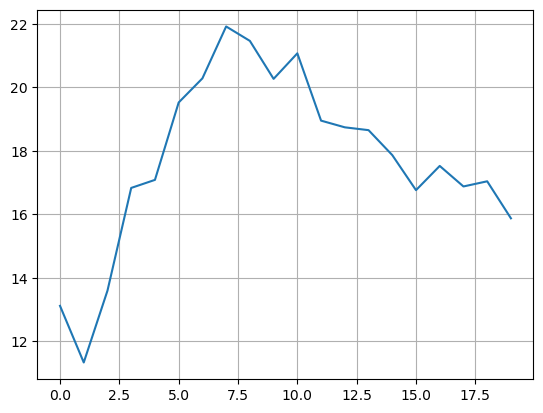

In [15]:
plt.plot(history_gen)
plt.grid(True)
plt.show()

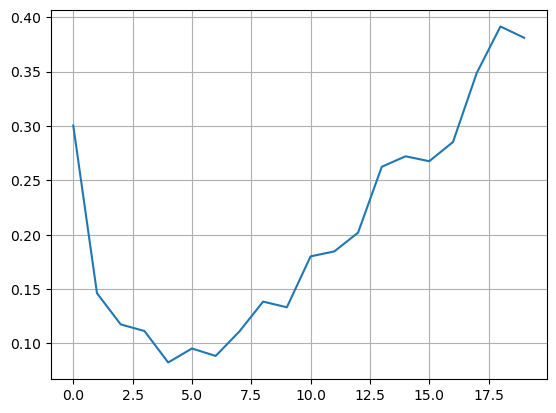

In [16]:
plt.plot(history_disc)
plt.grid(True)
plt.show()

1/1 [==============================] - 0s 31ms/step


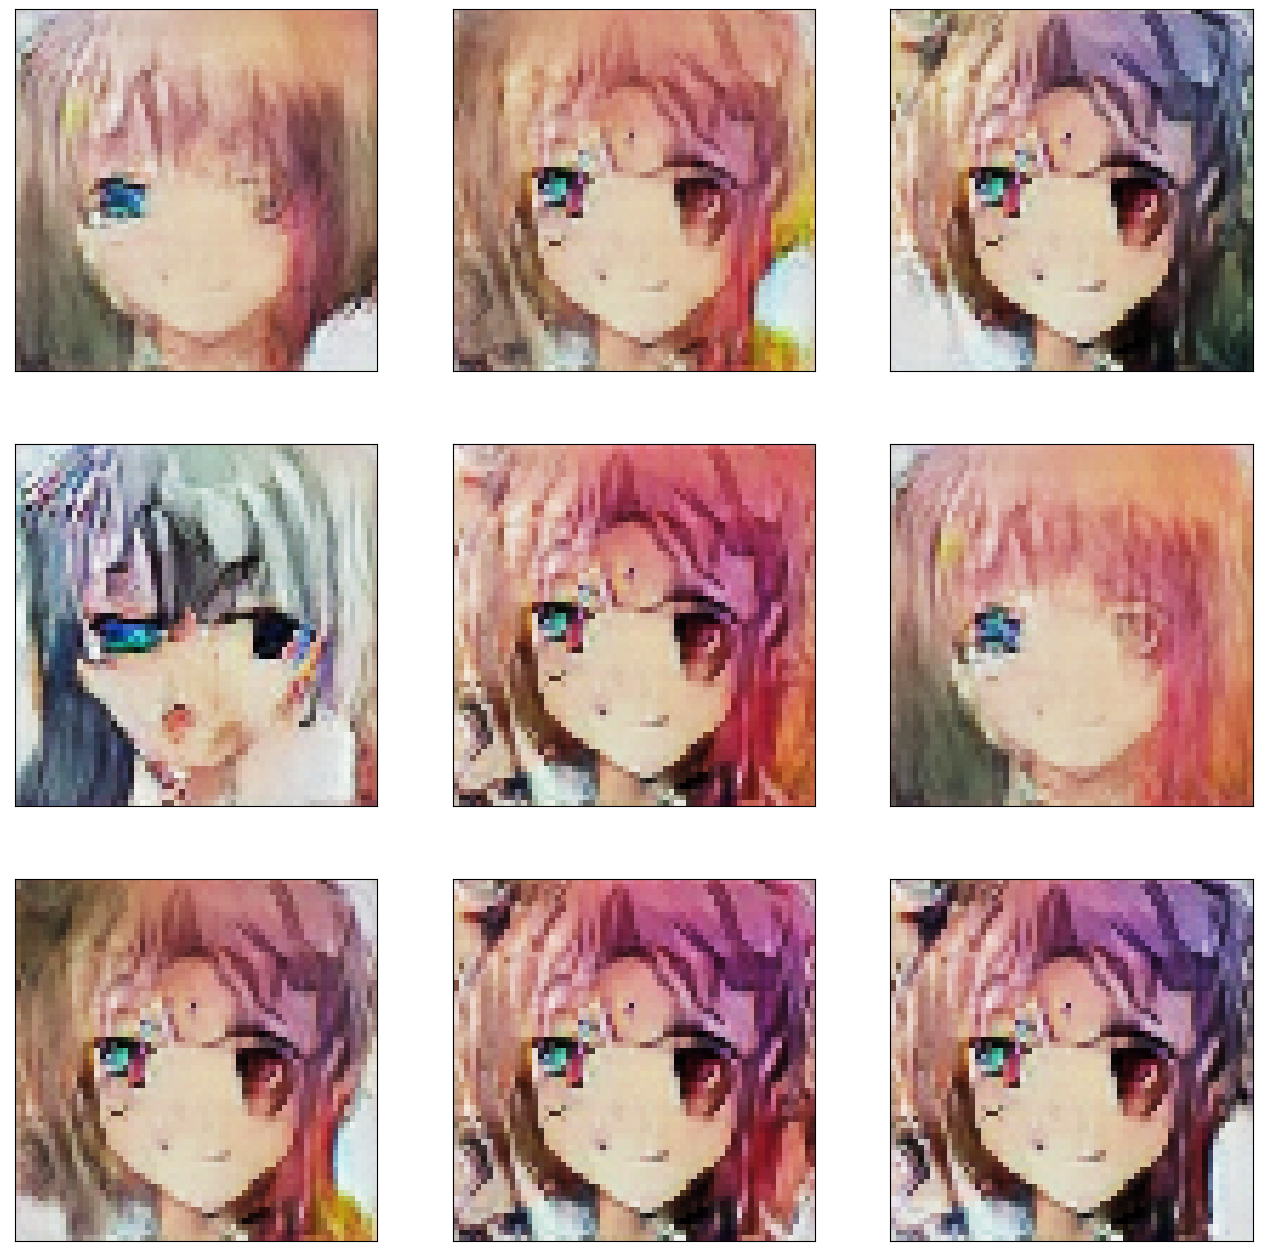

In [17]:
total = 3
plt.figure(figsize=(16, 16))

num = 1

for i in range(total*total):
    ax = plt.subplot(total, total, num)
    num += 1
    pred = tf.random.normal([1, hidden_dim])
    img = np.squeeze(generator.predict(pred), axis=0);
    plt.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)